# Theano 實例：Logistic 回歸

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T

Using gpu device 0: GeForce GTX 850M


## sigmoid 函數

一個 `logistic` 曲綫由 `sigmoid` 函數給出：
$$s(x) = \frac{1}{1+e^{-x}}$$

我們來定義一個 `elementwise` 的 sigmoid 函數：

In [2]:
x = T.matrix('x')
s = 1 / (1 + T.exp(-x))
sigmoid = theano.function([x], s, allow_input_downcast=True)

這裡 `allow_input_downcast=True` 的作用是允許輸入 `downcast` 成定義的輸入類型：

In [3]:
sigmoid([[ 0, 1],
         [-1,-2]])

array([[ 0.5       ,  0.7310586 ],
       [ 0.26894143,  0.11920293]], dtype=float32)

其圖像如下所示：

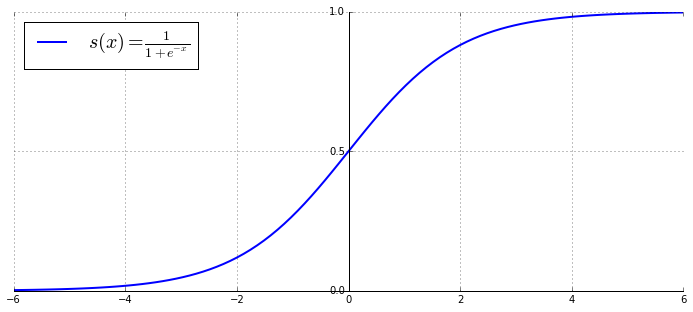

In [4]:
X = np.linspace(-6, 6, 100)
X = X[np.newaxis,:]

plt.figure(figsize=(12,5))

plt.plot(X.flatten(), sigmoid(X).flatten(), linewidth=2)

# 美化圖像的操作
#=========================
plt.grid('on')
plt.yticks([0,0.5,1])

ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))

plt.legend([r'$s(x)=\frac{1}{1+e^{-x}}$'], loc=0, fontsize=20)
#=========================

plt.show()

## sigmoid 函數與 tanh 函數的關係

`sigmoid` 函數與 `tanh` 之間有如下的轉化關係：
$$s(x)=\frac{1}{1+e^{-x}}=\frac{1+\tanh(x/2)}{2}$$

In [5]:
s2 = (1 + T.tanh(x / 2)) / 2

sigmoid2 = theano.function([x], s2)

sigmoid2([[ 0, 1],
          [-1,-2]])

array([[ 0.5       ,  0.7310586 ],
       [ 0.26894143,  0.11920291]], dtype=float32)

## logistic 回歸

簡單的二元邏輯回歸問題可以這樣描述：我們要對數據點 $x = (x_1, ..., x_n)$ 進行 0-1 分類，參數為 $w = (w_1, ..., w_n), b$，我們的假設函數如下：

$$
\begin{align}
h_{w,b}(x) & = P(Y=1|X=x) \\
& = sigmoid(z) \\
& =\frac{1}{1 + e^{-z}}\\
\end{align}
$$

其中

$$
\begin{align}
z & = x_1w_1 + ... + x_nw_n + b\\
& = w^T x + b\\
\end{align}
$$

對於一個數據點 $(x, y), y\in \{0,1\}$ 來說，我們的目標是希望 $h_{w,b}(x)$ 的值儘量接近於 $y$。

由於數值在 0-1 之間，我們用交叉熵來衡量 $h_{w,b}(x)$ 和 $y$ 的差異：

$$- y \log(h_{w,b}(x)) - (1-y) \log(1-h_{w,b}(x))$$

對於一組數據，我們定義損失函數為所有差異的均值，然後通過梯度下降法來優化損失函數，得到最優的參數 $w, b$。

## 實例

生成隨機數據：

In [6]:
rng = np.random

# 數據大小和規模
N = 400
feats = 784

# D = (X, Y)
D = (rng.randn(N, feats), rng.randint(size=N, low=0, high=2))

定義 `theano` 變數：

In [7]:
x = T.matrix('x')
y = T.vector('y')

# 要更新的變數：
w = theano.shared(rng.randn(feats), name='w')
b = theano.shared(0., name='b')

定義模型：

In [8]:
h = 1 / (1 + T.exp(-T.dot(x, w) - b))

當 $h > 0.5$ 時，認為該類的標籤為 1：

In [9]:
prediction = h > 0.5

損失函數和梯度：

In [10]:
cost = - T.mean(y * T.log(h) + (1 - y) * T.log(1 - h)) + 0.01 * T.sum(w ** 2)  # 正則項，防止過擬合
gw, gb = T.grad(cost, [w, b])

編譯訓練和預測函數：

In [11]:
train = theano.function(inputs=[x, y],
                        outputs=cost,
                        updates=[[w, w - 0.1 * gw], [b, b - 0.1 * gb]], 
                        allow_input_downcast=True)

predict = theano.function(inputs=[x],
                          outputs=prediction,
                          allow_input_downcast=True)

In [12]:
for i in xrange(10001):
    err = train(D[0], D[1])
    if i % 1000 == 0:
        print 'iter %5d, error %f' % (i, err)

iter     0, error 19.295896
iter  1000, error 0.210341
iter  2000, error 0.126124
iter  3000, error 0.124872
iter  4000, error 0.124846
iter  5000, error 0.124845
iter  6000, error 0.124845
iter  7000, error 0.124845
iter  8000, error 0.124845
iter  9000, error 0.124845
iter 10000, error 0.124845


查看結果：

In [13]:
print D[1]

[0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0]


In [14]:
print predict(D[0])

[0 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0
 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0
 0 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1
 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1
 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1
 0 0 1 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 1 0]
